In [1]:
import os
import math
import sys
import numpy as np
import torch
import random
import hydra
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from PIL import Image
import perturbations
import cv2
from torchsummary import summary
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

/home/wangqiurui/anaconda3/envs/strm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# >>> # Target are to be padded
# >>> T = 50      # Input sequence length
# >>> C = 20      # Number of classes (including blank)
# >>> N = 16      # Batch size
# >>> S = 30      # Target sequence length of longest target in batch (padding length)
# >>> S_min = 10  # Minimum target length, for demonstration purposes
# >>>
# >>> # Initialize random batch of input vectors, for *size = (T,N,C)

In [17]:
log_probs = torch.randn(100, 16, 20).log_softmax(2).detach().requires_grad_()
targets = torch.randint(1, 20, (16, 30), dtype=torch.long)
input_lengths = torch.full((16,), 100, dtype=torch.long)
target_lengths = torch.randint(10, 30, (16,), dtype=torch.long)
nn.CTCLoss()(log_probs, targets, input_lengths, target_lengths)

tensor(14.4500, grad_fn=<MeanBackward0>)

In [18]:
input_lengths,target_lengths

(tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 100]),
 tensor([26, 25, 11, 20, 12, 16, 24, 13, 27, 10, 11, 24, 23, 23, 24, 26]))

### t-sne

In [69]:
before = torch.randint(0,256,(3000,16,128))

In [10]:
label = torch.randint(0, 2, (3000,))

In [23]:
tsne = TSNE(n_components=2,perplexity=40, n_iter=300,n_jobs=-1,random_state=3407)

In [70]:
result = tsne.fit_transform(before.reshape(3000,-1))

In [72]:
resss = tsne.fit_transform(spitial_attention(128,16)(before)[0].detach().numpy().reshape(3000,-1))

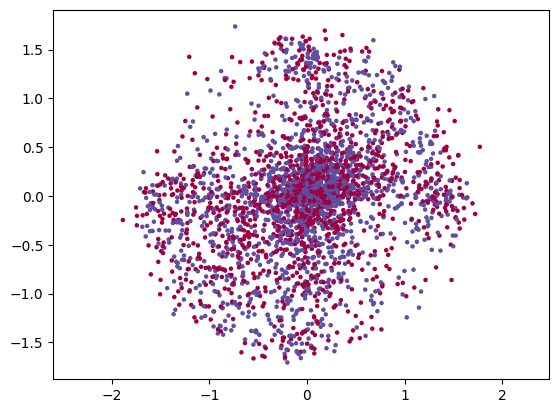

In [71]:
plt.scatter(result[:,0], result[:,1], c=label,s=5,cmap='Spectral')
# equal scaling on both axis and full range of data will be visible on the plot
plt.gca().set_aspect('equal', 'datalim')

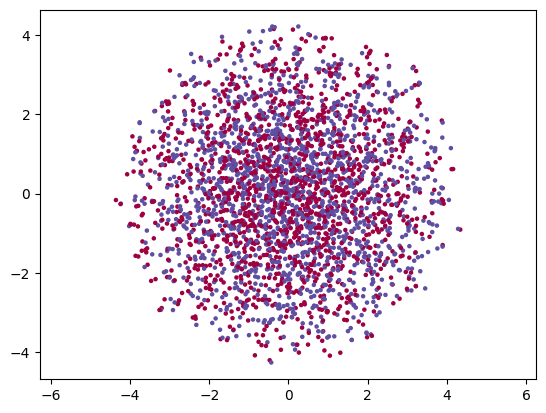

In [73]:
plt.scatter(resss[:,0], resss[:,1], c=label,s=5,cmap='Spectral')
# equal scaling on both axis and full range of data will be visible on the plot
plt.gca().set_aspect('equal', 'datalim')

In [2]:
# model = torchvision.models.resnet50(pretrained=True)
# res50 = nn.Sequential(*list(model.children())[:-2])

In [33]:
input = torch.randn(1,3,90, 256, 256)

In [2]:
res = torch.hub.load('/home/wangqiurui/.cache/torch/hub/facebookresearch_pytorchvideo_main/', 'slow_r50', trust_repo=True, source='local')

### seed

In [2]:
def seed_everything(seed=3407):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # torch.backends.cudnn.deterministic = True # type: ignore
    # torch.backends.cudnn.benchmark = False # type: ignore # if benchmark=True, deterministic will be False
    # prevent only sample one video
    #np.random.seed(seed)
    #random.seed(seed)
seed_everything()

### position_encoding

In [7]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000, pe_scale_factor=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.pe_scale_factor = pe_scale_factor
        # Compute the positional encodings once in log space.
        # pe is of shape max_len(5000) x 2048(last layer of FC)
        pe = torch.zeros(max_len, d_model,device='cpu')
        # position is of shape 5000 x 1
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) * self.pe_scale_factor
        pe[:, 1::2] = torch.cos(position * div_term) * self.pe_scale_factor
        # pe contains a vector of shape 1 x 5000 x 2048
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
                          
    def forward(self, x):
       x = x + self.pe[:, :x.size(1)] # type: ignore
       return self.dropout(x)

### spitial attention

In [8]:
class sub_linear(nn.Module):
    def __init__(self,dim):
        super(sub_linear,self).__init__()
        self.in_feature = nn.Linear(dim,dim//2)   # 2048 -> 1024
        self.hidden = nn.Linear(dim//2,dim//2)
        self.out_feature = nn.Linear(dim//2,dim)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        out = self.in_feature(x)    # 2048 -> 1024
        out = self.relu(out)
        out = self.hidden(out)
        out = self.relu(out)
        out = self.out_feature(out)
        return out + x              # b x 16 x 2048

In [9]:
class spitial_attention(nn.Module):
    def __init__(self,trans_linear_in_dim,patch_numbers):
        super(spitial_attention, self).__init__()
        self.query_projection = nn.Linear(trans_linear_in_dim,trans_linear_in_dim)
        self.key_projection = nn.Linear(trans_linear_in_dim,trans_linear_in_dim)
        self.value_projection = nn.Linear(trans_linear_in_dim,trans_linear_in_dim)

        self.position_encoding = PositionalEncoding(512,0.1)
        self.softmax = nn.Softmax(dim=-1)

        # treat gamma as a learnable parameter
        self.gamma = nn.Parameter(torch.zeros(1))
        self.sub_linear = sub_linear(trans_linear_in_dim)

    def forward(self,x):
        '''
            input: [seq_len,patch_numbers,channel]
            return: attention + input, same shape
        '''

        x = self.position_encoding(x)
        residual = x

        query = self.query_projection(x) #[]
        key = self.key_projection(x)
        value = self.value_projection(x)
        
        attention,attn_map = self.Attention(query,key,value,True,0.1)

        out = self.gamma * attention + residual
        out = self.sub_linear(out)
        return out,attn_map

    # N: token number, D: token dim
    # Q,K,V: query (seq_len, 4x4, channel)
    # use_DropKey: whether use DropKey 
    # mask_ratio: ratio to mask
    def Attention(self,Q, K, V, use_DropKey, mask_ratio):
        attn = torch.bmm((Q * (Q.shape[1] ** -0.5)) , K.permute(0,2,1)) # (frame_counts, 4x4, 4x4)
        # use DropKey as regularizer
        if use_DropKey == True:
            m_r = torch.ones_like(attn) * mask_ratio 
            attn = attn + torch.bernoulli(m_r) * -1e12
        attn_map = attn.clone()
        attn_map = nn.Softmax(dim=-1)(attn_map)
        attn = nn.Softmax(dim=-1)(attn)
        x = torch.bmm(attn , V) # (frame_counts, 4x4, channel)
        return x,attn_map

        


In [10]:
z = torch.randn(160,16,512)
spitial_attention(512,16)(z)[0].shape

torch.Size([160, 16, 512])

### todo: draw feature map use different methods

In [ ]:
a,b = spitial_attention(2048,16)(out.unsqueeze(0).reshape(-1,2048,16).transpose(2,1))

In [28]:
b.shape

torch.Size([8, 16, 16])

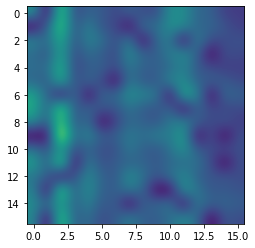

In [30]:
import matplotlib.pyplot as plt

# Visualize the attention map
plt.imshow(b[7].detach().numpy(),cmap='viridis', interpolation='bicubic')
plt.show()

### temporal_attention

In [6]:
class channel_linear(nn.Module):
    def __init__(self,channek_dim):
        super(channel_linear,self).__init__()
        self.in_feature = nn.Linear(channek_dim,channek_dim)
        self.out_feature = nn.Linear(channek_dim,channek_dim)
        self.relu = nn.ReLU()
    def forward(self,x):
        # [B,seq_len,channel]
        out = self.in_feature(x)
        out = self.relu(out)
        out = self.out_feature(out)
        return out            # need residual connection???

class channel_attention(nn.Module):
    def __init__(self,channel_dim):
        super(channel_attention,self).__init__()
        self.conv1 = nn.Conv1d(channel_dim,channel_dim,1)
        self.channel_linear = channel_linear(channel_dim)

    def forward(self,x):
        '''
            input: [frame_counts,16,channel]
            return: attention + input, same shape
        '''
        fc = x.shape[0]
        residual1 = x
        x = x.transpose(2,1).reshape(-1,512,16)
        x = self.conv1(x).transpose(2,1)
        x = self.channel_linear(x).reshape(fc,16,512) + residual1
        # [seq_len,16,channel]
        return x

In [32]:
ta = torch.randn(1,8,16,512)
channel_attention(512)(ta).shape

torch.Size([1, 8, 16, 512])

### sampler

In [7]:
def order_topk(x, k=10):
    if len(x.shape) > 2:
        x = x[:,:,0]
    return F.one_hot(torch.sort(torch.topk(x, k=10, dim=-1)[-1])[0], list(x.shape)[-1]).transpose(-1,-2).float()
class Generator(nn.Module):
    def __init__(self, insize=512, outsize=512, z_dim=64, bias=False):
        super().__init__()
        self.insize = insize
        self.outsize = outsize
        self.z_dim = z_dim
        self.bias = bias
        self.encoder = nn.Linear(insize, z_dim * 2)
        if bias:
            self.gen = nn.Linear(z_dim, outsize + 1)
        else:
            self.gen = nn.Linear(z_dim, outsize)

    def forward(self, task_context):
        # task_context: , insize
        distribution = self.encoder(task_context) # , mu_size * 2
        mu = distribution[:self.z_dim]
        log_var = distribution[self.z_dim:]

        z_signal = torch.randn(1, self.z_dim).cuda()
        z_mu = mu.unsqueeze(0) # 1, z_dim
        z_log_var = log_var.unsqueeze(0) # 1, z_dim
        z = z_mu + torch.exp(z_log_var/2) * z_signal # 1, z_dim

        weight_bias = self.gen(z) # 1, out_size * 2
        weight = weight_bias[:, :self.outsize] # 1, out_size
        weight = weight / torch.norm(weight, 2) # normalize 
        if self.bias:
            bias = weight_bias[0, self.outsize:] # ,1
            return weight, bias
        else:
            return weight

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        self.dim = d_model
        self.seq_len = max_len
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x.view(-1, self.seq_len, self.dim)
        x = x + self.pe[:,:]
        return x.view(-1, self.dim)

class Sampler(nn.Module):
    def __init__(self,args):
        super(Sampler,self).__init__()
        self.args = args
        self.generator = Generator()
        if self.args.ada:
            self.evaluator = nn.Sequential(PositionalEmbedding(d_model=1024, max_len=self.args.sampler_seq_len),
                                            nn.Linear(1024, 512),
                                            nn.ReLU(),
                                            )
        else:
            self.evaluator = nn.Sequential(PositionalEmbedding(d_model=1024, max_len=self.args.sampler_seq_len),
                                            nn.Linear(1024, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 1),
                                            )
        self.func = order_topk
    def return_topk_func(self):
        iteration = self.args.current_iter
        if iteration == 1:
            print('Initial sigma as', self.args.sigma)
            self.args.current_sigma = self.args.sigma
        sigma_min = 0.01
        step = self.args.sigma_step
        if self.args.sigma_decay and (iteration + 1) % step == 0:
            self.args.current_sigma = self.args.sigma * ((0.8) ** ((iteration + 1) // step))
            if self.args.current_sigma < sigma_min:
                self.args.current_sigma = sigma_min
            print('Decay sigma, the current sigma is {:.2}:'.format(self.args.current_sigma))
        topk_func = perturbations.perturbed(self.func, 
                                            num_samples=self.args.num_samples,
                                            sigma=self.args.current_sigma,
                                            noise=self.args.noise,
                                            batched=True)
        return topk_func


    def fast_topk(self, x):
        return F.one_hot(torch.sort(torch.topk(x, k=self.args.k, dim=-1)[-1])[0], list(x.shape)[-1]).transpose(-1,-2).float()
    

    def forward(self, x, weight = None, category='support'):
        # [B, 1024, 40]
        x = x.transpose(-1,-2) # [B, 40, 1024]
        dim,n = x.shape[1],x.shape[2]
        feature = x

        # Calculate the global feature of the whole video as a kind of guidance
        if self.args.shot > 1:
            info_g = x.view(self.args.way, -1, *x.shape[1:]) # way, shot, frame, dim
            shot = info_g.size(1)
            info_g = info_g.mean(dim=-3, keepdim=True).mean(dim=-2) # way, 1, dimseq_len
            info_g = info_g.repeat(shot, 1, 1).expand(-1, self.args.sampler_seq_len, -1) # way * shot, 1, dim --> way * shot, frame, dim
        else:
            info_g = x.mean(dim=-2, keepdim=True).expand(-1, self.args.sampler_seq_len, -1) # (way * shot, 1, dim) expand to --> (way * shot, frame, dim)

        # Calculate the task feature
        task_f = info_g[:,0,:].mean(dim=0) # ,dim

        # Feed into Evaluator to get scores
        x = torch.cat((x, info_g), dim=-1) # way * shot, frame, 2*dim

        score = self.evaluator(x.view(n, dim*2)) # way * shot * frame, 1 (if task_ada, way * shot * frame, weight_dim)
        #==== Dynamic linear weight generation =====
        if self.args.ada:
            if category == 'support':
                weight = self.generator(task_f) # weight: 1, weight_dim, bias: weight_dim
            else:
                assert weight!=None # If query samples, weight should be given
            score = F.linear(score, weight)

        # Normalize score with min-max
        score = score.view(-1, self.args.sampler_seq_len) # way * shot, frame
        safe_min_value = 1e-4
        norm_score = (score - score.min(dim=1, keepdim=True)[0]) / (score.max(dim=1, keepdim=True)[0]- score.min(dim=1, keepdim=True)[0] + safe_min_value) # way * shot, frame

        if self.training:
            score = norm_score.unsqueeze(-1).expand(-1,-1,self.args.k) # way * shot, frame, k
            topk_func = self.return_topk_func()
            indices = topk_func(score) # way * shot, frame, k
        else:
            indices = self.fast_topk(norm_score)
        #seleted_score = torch.bmm(indices.transpose(-1,-2), )
        indices = indices.transpose(-1,-2) # way * shot, k, frame
        selected_feature = torch.bmm(indices, feature)

        return indices,selected_feature,feature

### TSN-transformer

#### 1.0

In [6]:
class Positional_Encoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(Positional_Encoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self,args):
        super(ScaledDotProductAttention, self).__init__()
        self.args = args

    def forward(self, Q, K, V):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        score = torch.matmul(Q, K.transpose(-1,-2)) / np.sqrt(self.args.d_k) # score: [batch_size, n_heads, len_q, len_k]
        att = nn.Softmax(dim=-1)(score) # att: [batch_size, n_heads, len_q, len_k]
        context = torch.matmul(att, V)  # context [batch_size, n_heads, len_q, d_v]
        return context, att

class MultiHeadAttention(nn.Module):
    def __init__(self,args):
        super(MultiHeadAttention,self).__init__()
        self.args = args
        self.W_Q = nn.Linear(args.d_model, args.d_k * args.n_heads, bias=False)
        self.W_K = nn.Linear(args.d_model, args.d_k * args.n_heads, bias=False)
        self.W_V = nn.Linear(args.d_model, args.d_v * args.n_heads, bias=False)
        self.fc = nn.Linear(args.n_heads * args.d_v, args.d_model, bias=False)
    def forward(self,q,k,v):
        '''
        w_q,w_k,w_v: [batch_size, seq_len, d_model]
        '''
        residual, batch_size = q, q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(q).view(batch_size, -1, self.args.n_heads, self.args.d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(k).view(batch_size, -1, self.args.n_heads, self.args.d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(v).view(batch_size, -1, self.args.n_heads, self.args.d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        content,attention = ScaledDotProductAttention(self.args)(Q,K,V)
        content = content.transpose(1,2).contiguous().view(batch_size, -1, self.args.n_heads * self.args.d_v)
        output = self.fc(content)
        output = nn.LayerNorm(self.args.d_model).cuda()(output + residual)
        return output, attention


class PoswiseFeedForwardNet(nn.Module):
    def __init__(self,args):
        super(PoswiseFeedForwardNet,self).__init__()
        self.args = args
        self.fc = nn.Sequential(
            nn.Linear(self.args.d_model, self.args.d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(self.args.d_ff, self.args.d_model, bias=False)
        )
    def forward(self,input):
        residual = input 
        output = self.fc(input)

        return nn.LayerNorm(self.args.d_model).cuda()(output + residual)


In [5]:
class EncoderLayer(nn.Module):
    def __init__(self,args):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(args)
        self.pos_ffn = PoswiseFeedForwardNet(args)
    def forward(self,query_sequence,support_sequence):
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        encoder_output, _ = self.enc_self_attn(query_sequence,query_sequence,support_sequence)
        encoder_output = self.pos_ffn(encoder_output)
        return encoder_output


class Encoder(nn.Module):
    def __init__(self,args):
        super(Encoder,self).__init__()
        self.positionalencoding = Positional_Encoding(args.d_model,0.1)
        self.encoder_layers = nn.ModuleList([EncoderLayer(args) for _ in range(6)])
    def forward(self,query_sequence,support_sequence):
        query_sequence = self.positionalencoding(query_sequence)
        support_sequence = self.positionalencoding(support_sequence)
        for encoder_layer in self.encoder_layers:
            query_sequence = encoder_layer(query_sequence,support_sequence)
        return query_sequence
        
        

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.average = nn.AdaptiveAvgPool1d(100)
        self.tcn =  nn.Conv1d(512, 512, 1)
        self.decode = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32,1),
        )
        self.predict = nn.Linear(100, 2)
    
    def forward(self, x):
        x = self.tcn(x.transpose(1,2)).transpose(1,2)

        x = self.average(x.transpose(1,2)).transpose(1,2)
        x = self.decode(x)
 
        x = x.reshape(-1)
        
        x = self.predict(x)
        return x

In [12]:
class TSN_Transformer(nn.Module):
    def __init__(self,args):
        super(TSN_Transformer,self).__init__()
        self.encoder = Encoder(args)
        self.decoder = Decoder()

    def forward(self,query_sequence,support_sequence):
        '''
        query_sequence: [batch_size, seq_len, d_model]
        support_sequence: [batch_size, seq_len, d_model]
        '''
        query_sequence = self.encoder(query_sequence,support_sequence)
        out = self.decoder(query_sequence)
        return out
        

#### 2.0 (change encoderlayer only process query feature, decoder layer process both)

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self,args):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(args)
        self.pos_ffn = PoswiseFeedForwardNet(args)
    def forward(self,query_sequence):
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        encoder_output, _ = self.enc_self_attn(query_sequence,query_sequence,query_sequence)
        encoder_output = self.pos_ffn(encoder_output)
        return encoder_output

class Encoder(nn.Module):
    def __init__(self,args):
        super(Encoder,self).__init__()
        self.positionalencoding = Positional_Encoding(args.d_model,0.1)
        self.encoder_layers = nn.ModuleList([EncoderLayer(args) for _ in range(6)])
    def forward(self,query_sequence):
        query_sequence = self.positionalencoding(query_sequence)
        for encoder_layer in self.encoder_layers:
            query_sequence = encoder_layer(query_sequence)
        return query_sequence

In [11]:
class Decoderlayer(nn.Module):
    def __init__(self,args):
        super(Decoderlayer,self).__init__()
        self.dec_self_attn = MultiHeadAttention(args)
        self.enc_dec_attention = MultiHeadAttention(args)
        self.pos_ffn = PoswiseFeedForwardNet(args)

    def forward(self,query_sequence,support_sequence):
        query_sequence, _ = self.dec_self_attn(query_sequence,query_sequence,query_sequence)
        decoder_output, _ = self.enc_dec_attention(query_sequence,support_sequence,support_sequence)
        decoder_output = self.pos_ffn(decoder_output)
        return decoder_output

class Decoder(nn.Module):
    def __init__(self,args):
        super(Decoder,self).__init__()
        self.positionalencoding = Positional_Encoding(args.d_model,0.1)
        self.decoder_layers = nn.ModuleList([Decoderlayer(args) for _ in range(6)])
    def forward(self,query_sequence,support_sequence):
        support_sequence = self.positionalencoding(support_sequence)
        for decoder_layer in self.decoder_layers:
            query_sequence = decoder_layer(query_sequence,support_sequence)
        return query_sequence
        

In [20]:
class TSN_Transformer(nn.Module):
    def __init__(self,args):
        super(TSN_Transformer,self).__init__()
        self.encoder = Encoder(args)
        self.decoder = Decoder(args)
        self.average = nn.AdaptiveAvgPool1d(100)
        self.projection = nn.Linear(51200,2)

    def forward(self,query_sequence,support_sequence):
        '''
        query_sequence: [batch_size, seq_len, d_model]
        support_sequence: [batch_size, seq_len, d_model]
        '''
        encoder_output = self.encoder(query_sequence)
        out = self.decoder(encoder_output,support_sequence)
        out = self.average(out.transpose(1,2)).transpose(1,2)
        out = self.projection(out.reshape(-1))
        return out
        

#### define

In [13]:
class ArgsObject(object):
    def __init__(self):
        # resnet50 -> 2048, resnet18 -> 512
        self.trans_linear_in_dim = 128
        self.patch_numbers = 16
        #self.seq_len = 8
        self.number_of_class = 200
        self.shot = 1
        self.d_model = 512
        # Transformer Parameters
        self.d_ff = 2048 # FeedForward dimension
        self.d_k =64
        self.d_v = 64  # dimension of K(=Q), V
        self.n_layers = 6  # number of Encoder of Decoder Layer
        self.n_heads = 8  # number of heads in Multi-Head Attention

args = ArgsObject()

#### test former

In [21]:
TSN_Transformer(args).cuda()(torch.randn(1,300,512).cuda(),torch.randn(1,300,512).cuda()).shape

torch.Size([2])

### model： average the channel dimension to decrease compute(decouple), actionformer type e,decoder for regression? for regression,fully utlize the temporal information and average the channel dimension,then use temporal convolutional network，for classfication, utilze temporal selection(TS) and patch self-attention in untrimmed query set, the trimmed support set only psa,

### ablation study (sample numbers)

### 12/14 todo: add sampler to query, use tsn-former to locate action

In [50]:
class RSTRM(nn.Module):
    def __init__(self,args):
        super(RSTRM,self).__init__()
        self.args = args
        self.tsn_transformer = TSN_Transformer(args) # [bs,seq_len,channel(dmodel)],[bs,seq_len,channel(dmodel)] -> 2
        self.sampler = Sampler(args) # inuput:[bs,channel,40] -> indices [bs,8,40] * reshape_feature [bs,40,-1] = [bs,8,512,4,4]

        if args.dataset == 'ActivityNet':
            self.class_numbers = 200

        self.spitial_attention = spitial_attention(self.args.trans_linear_in_dim,self.args.patch_numbers)
        self.support_channel_attention = channel_attention(self.args.trans_linear_in_dim)
        self.query_channel_attention = channel_attention(self.args.trans_linear_in_dim)
        self.averagepool = nn.AdaptiveAvgPool3d((40,None,None))

        if args.use_conv:
            self.classfication = nn.Sequential(nn.Conv3d(args.trans_linear_in_dim,256,(1,1,1)),
                                               nn.ReLU(),
                                               nn.Linear(81920,self.class_numbers))
        else:
            self.classfication = nn.Linear(163840,self.class_numbers)

        self.softmax = nn.Softmax(dim=-1)
        self.relu = nn.ReLU()

    def forward(self,query_feature,support_feature):

        # self.arg.seq_len = support_videos.shape[2]
        self.query_seq_len = query_feature.shape[2]
        # dynamic seq_len ??????
        
        query_feature = query_feature.squeeze(0) # [1,channel,seq_len,4,4] -> [channel,seq_len,4,4]
        query_feature = query_feature.reshape(-1,self.args.trans_linear_in_dim,self.args.patch_numbers).transpose(2,1) # [channel,seq_len,4,4] -> [seq_len,4x4,channel]
        query_spitial_attention_feature,query_attn_map = self.spitial_attention(query_feature) # [seq_len,4x4,channel] 160,16,512

        query_spitial_channel_attention_feature = self.query_channel_attention(query_spitial_attention_feature) # [seq_len,16,channel]

        # for classify query feature use sampler
        query_spitial_channel_attention_feature = query_spitial_channel_attention_feature.reshape(self.args.trans_linear_in_dim,-1,4,4).unsqueeze(0) # [1,512,seq_len,4,4]
        average_qf = self.averagepool(query_spitial_channel_attention_feature) # [bs,channel,40,4,4]
        sampler_infea = average_qf.mean(dim=-1).mean(dim=-1) # [bs,channel,40]
        indices,_,_ = self.sampler(sampler_infea) # inuput:[bs,channel,40] -> indices [bs,10,40] * reshape_feature [bs,40,-1] = [bs,10,512,4,4]
        sampled_feature = torch.bmm(indices,average_qf.reshape(1,self.args.sampler_seq_len,-1)).reshape(1,-1,10,4,4) # [bs,512,10,4,4]


        if self.args.shot == 1:
            # for 1 way 1 shot, we only need to tackle the support video once
            support_feature = support_feature.squeeze(0)
            support_feature = support_feature.reshape(-1,self.args.trans_linear_in_dim,self.args.patch_numbers).transpose(2,1) # [channel,seq_len,4,4] -> [seq_len,4x4,channel]
            support_spitial_attention_feature,support_attn_map = self.spitial_attention(support_feature) # [seq_len,4x4,channel]

            support_spitial_channel_attention_feature = self.support_channel_attention(support_spitial_attention_feature) # [seq_len,16,channel]
            seq_len = support_spitial_channel_attention_feature.shape[0]
            # choose 10 seq_len to contact from support feature evenly [seq_len,16,channel] -> [10,16,channel]
            choosed_support_feature = support_spitial_channel_attention_feature[torch.linspace(0, seq_len-1, self.args.k).long()] # [seq_len,16,channel] -> [sampler_seq_len,16,channel]

            # contact 8 seq_len query video [8,512,4,4] and support video [seq_len,16,512] for classification
            classify_f = torch.concat((sampled_feature.squeeze(0).reshape(-1,self.args.patch_numbers,self.args.trans_linear_in_dim),choosed_support_feature),dim=0) #[20,16,512]
            # need conv???
            logits = self.classfication(classify_f.reshape(-1))


            # regression
            aug_query_feature = (sampled_feature.mean(dim=2,keepdim=True) + query_spitial_channel_attention_feature).mean(-1).mean(-1) #[1,512,seq_len]
            support_spitial_channel_attention_feature = F.interpolate(support_spitial_channel_attention_feature.mean(-2).unsqueeze(0).transpose(1,2),size=(aug_query_feature.shape[2]),mode='nearest') #[1,512,seq_len] linear?
            reg = self.tsn_transformer(aug_query_feature.transpose(1,2),support_spitial_channel_attention_feature.transpose(1,2))
        
            return logits,reg,query_attn_map,support_attn_map


### test conv1d and linear

In [19]:
j = torch.rand(40,20).cuda()
conv = nn.Conv1d(20,10,1).cuda()
linear = nn.Linear(20,10).cuda()

In [21]:
conv(j.transpose(0,1)).shape,linear(j).shape

(torch.Size([10, 40]), torch.Size([40, 10]))

### test model

In [51]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# with tf.compat.v1.Session(config=config) as session:
class ArgsObject(object):
    def __init__(self):
        # resnet50 -> 2048, resnet18 -> 512
        self.trans_linear_in_dim = 512
        self.patch_numbers = 16
        #self.seq_len = 8
        self.number_of_class = 200
        self.shot = 1
        self.way = 1
        self.sampler_seq_len = 40
        self.num_gpus = 1
        self.k = 10
        self.sigma = 0.05
        self.sigma_decay = True
        self.num_samples = 500
        self.noise = 'normal'
        self.current_iter = 1
        self.sigma_step = 1000
        self.dropout = 0.1
        self.ada = True
        self.d_model = 512
        # Transformer Parameters
        self.d_ff = 2048 # FeedForward dimension
        self.d_k =64
        self.d_v = 64  # dimension of K(=Q), V
        self.n_layers = 6  # number of Encoder of Decoder Layer
        self.n_heads = 8  # number of heads in Multi-Head Attention
        self.dataset = 'ActivityNet'
        self.use_conv = False

args = ArgsObject()
model = RSTRM(args).cuda()
support_imgs = torch.rand(1,512,36,4,4).cuda()
target_imgs = torch.rand(1,512,128,4,4).cuda()
a,b,c,d = model(target_imgs,support_imgs)

Initial sigma as 0.05


In [52]:
a

tensor([-0.3414, -0.0210,  0.1614,  0.2879, -0.0611,  0.3169,  0.6207, -0.6594,
        -0.0363,  0.4120, -0.2044, -0.0567,  0.0757,  0.2100, -0.0667, -0.0834,
         0.3071, -0.2312, -0.0517,  0.4379, -0.0210,  0.0386, -0.0041, -0.2635,
        -0.2657, -0.2894,  0.4031, -0.5793,  0.5797, -0.3491, -0.4437, -0.1181,
        -0.0839,  0.0106,  0.2115,  0.3636, -0.6748, -0.3337, -0.4306,  0.3082,
        -0.0251, -0.2384,  0.2255, -0.1418, -0.0541,  0.1452,  0.0970,  0.4279,
        -0.3108,  0.1777, -0.0626,  0.2126,  0.0108,  0.2620,  0.3207, -0.6381,
        -0.2847,  0.3841, -0.0852,  0.0421,  0.6961,  0.0253,  0.0551,  0.0678,
         0.4630,  0.0960, -0.6062,  0.2694, -0.0419,  0.0168, -0.1546, -0.0139,
        -0.0361,  0.4450,  0.3301, -0.4402,  0.5403,  0.0267, -0.2201, -0.1787,
         0.0326, -0.1956, -0.2317, -0.0899,  0.4944,  0.0456,  0.0781,  0.3681,
         0.0524,  0.1551,  0.1786, -0.2036,  0.0661,  0.1302, -0.3855, -0.6440,
        -0.0689,  0.2569,  0.5140,  0.08

In [42]:
a.argmax(dim=-1)

tensor(121, device='cuda:0')

In [53]:
b

tensor([-0.0105,  0.0967], device='cuda:0', grad_fn=<AddBackward0>)

In [54]:
class_label = torch.rand(1).cuda()
locate_label = torch.randn((2,)).cuda()

In [55]:
class_label,locate_label

(tensor([0.5642], device='cuda:0'),
 tensor([ 0.1379, -0.0194], device='cuda:0'))

In [57]:
nn.CrossEntropyLoss()(a.unsqueeze(0),class_label.long())

tensor(5.7144, device='cuda:0', grad_fn=<NllLossBackward0>)

In [56]:
F.cross_entropy(a.unsqueeze(0),class_label.long())

tensor(5.7144, device='cuda:0', grad_fn=<NllLossBackward0>)

In [58]:
loss = torch.nn.MSELoss(reduction='sum')
output = loss(b, locate_label)
print(output)


tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)


In [59]:
(F.cross_entropy(a.unsqueeze(0),class_label.long()) + output).backward()

In [32]:
@hydra.main(config_path="config", config_name="config",version_base=None)
def main(cfg):
    print(cfg)
    return